# Support Vector Machines for text classification

In [1]:
# Required basic imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import re
import os
import string
import joblib
from pathlib import Path

# Imports for tokenizing and vectorizing data
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Imports for vectorized data pre-processing and classification models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import unicodedata

## Data preprocessing

### First, define auxiliary functions

In [2]:
def clear_tokens(tokens_list: list) -> None:
    """ Removes punctuation symbols from the given tokens list """
    # Traverse the list backwards to avoid logic problems with pop() and indexes order
    for i in range(len(tokens_list) - 1, -1, -1):
        if tokens_list[i] in string.punctuation:
            tokens_list.pop(i)
    return

def remove_emojis(keyword):
    return re.sub(r"[^\w\s,!?@#áéíóúÁÉÍÓÚñÑ]", "", keyword)

### Tokenize with TweetTokenizer and vectorize with TF-IDF

In [3]:
def tokenize_and_vectorize(data_path: str, 
                           treat_emojis: bool=False,
                           verbose: bool=False,
                           trained_vectorizer=False) -> tuple:
    """ Tokenizes the messages from all the users and computes vectors from them """
    path            = Path(data_path)
    all_users_data  = []
    tokenizer       = TweetTokenizer()
    vectorizer      = TfidfVectorizer()
    users_order     = [] # List that stores the users in the order that are processed, for merging with the target

    # Iterate through the JSON data folder
    for element in path.iterdir():
        if element.is_file():
            user_id = re.findall(pattern=r"[0-9]+", string=element.name)[0]
            users_order.append(user_id)

            # Some execution verbose
            if verbose:
                print(f"Tokenizing messages from user: {user_id}")

            # Open and read the current JSON file
            with open(data_path + f'/{element.name}') as json_file:
                json_data = json.load(fp=json_file)

                if treat_emojis:
                    # Emojis must be deleted from the messages
                    messages = [ remove_emojis(str(record['message'])) for record in json_data ]

                else:
                    # Preserve emojis in the messages
                    messages = [ str(record['message']) for record in json_data ]

                # Apply the TweetTokenizer algorithm
                tokenized = [ tokenizer.tokenize(m) for m in messages ]

                # Remove punctuation symbols tokens
                for i, t in enumerate(tokenized):
                    clear_tokens(tokens_list=t)

                    # If the resulting list is empty, then remove it
                    if len(t) == 0:
                        tokenized.pop(i)
                
                # Join the tokens of a single message, since that is what expects the implementation of TF-IDF
                user_document = " ".join(tokenized[0])
                for i in range(1, len(tokenized)):
                    tokens_joined = " ".join(tokenized[i])
                    user_document += " " + tokens_joined
            
                # Merge the previous data with the current user's
                all_users_data.append(user_document)

    # Vectorize all the messages with the TF-IDF and return the data as a Pandas DataFrame
    if trained_vectorizer:
        X = trained_vectorizer.transform(all_users_data)
        df = pd.DataFrame(X.toarray(), columns=trained_vectorizer.get_feature_names_out())
    else:
        X  = vectorizer.fit_transform(all_users_data)
        df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    
    return df, users_order, vectorizer

In [4]:
# Get the data from all users
data_path_task1                        = os.getcwd() + '/data/task1/complete/subjects/'
data_path_task2                        = os.getcwd() + '/data/task2/complete/subjects/'
# data_path_task1                        = os.getcwd() + '/data/task1/train/subjects/'
# data_path_task2                        = os.getcwd() + '/data/task2/train/subjects/'
df_vectorized_task1, users_order_task1, vectorizer_task1 = tokenize_and_vectorize(data_path=data_path_task1, treat_emojis=True, verbose=False)
df_vectorized_task2, users_order_task2, vectorizer_task2 = tokenize_and_vectorize(data_path=data_path_task2, treat_emojis=True, verbose=False)

In [5]:
# Show the first five elements of each Pandas DataFrae
df_vectorized_task1.head()

,00,000,0000,0000000,00000000000,00000085,00000110,0000014,0000017,000003,...,últimamente,últimas,último,últimos,ún,única,únicamente,único,únicos,útiles
0,0.031401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df_vectorized_task2.head()

,00,000,0000,0000000,00000000000,00000085,00000110,0000014,0000017,000003,...,últimamente,últimas,último,últimos,ún,única,únicamente,único,únicos,útiles
0,0.031401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Build the supervised datasets (with the target variable)

In [7]:
# Get the data from the target variable
target_path_task1 = os.getcwd() + '/data/task1/complete/gold_task1.txt'
target_path_task2 = os.getcwd() + '/data/task2/complete/gold_task2.txt'

target_col_task1  = pd.read_csv(filepath_or_buffer=target_path_task1, delimiter=',').to_numpy()
users_tags_task1  = { re.findall(r"[0-9]+", target_col_task1[i][0])[0]: target_col_task1[i][1] for i in range(len(target_col_task1)) }

target_col_task2  = pd.read_csv(filepath_or_buffer=target_path_task2, delimiter=',').to_numpy()
users_tags_task2  = { re.findall(r"[0-9]+", target_col_task2[i][0])[0]: target_col_task2[i][1] for i in range(len(target_col_task2)) }

# Create copies of each dataset
df_supervised_task1 = df_vectorized_task1.copy()
df_supervised_task2 = df_vectorized_task2.copy()

# Create the target column in order and add it to the Pandas DataFrame
target_task1 = np.array([ users_tags_task1[user_id] for user_id in users_order_task1 ], np.int8)
df_supervised_task1.insert(loc=len(df_supervised_task1.columns), column='Target', value=target_task1)

target_task2 = np.array([ users_tags_task2[user_id] for user_id in users_order_task2 ])
df_supervised_task2.insert(loc=len(df_supervised_task2.columns), column='Target', value=target_task2)

# Show the first five rows of each Pandas DataFrame
df_supervised_task1.head()

,00,000,0000,0000000,00000000000,00000085,00000110,0000014,0000017,000003,...,últimas,último,últimos,ún,única,únicamente,único,únicos,útiles,Target
0,0.031401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [8]:
df_supervised_task2.head()

,00,000,0000,0000000,00000000000,00000085,00000110,0000014,0000017,000003,...,últimas,último,últimos,ún,única,únicamente,único,únicos,útiles,Target
0,0.031401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,betting
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,trading
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,trading
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,trading
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,trading


## Training the baseline model - Task 1

### Base model - SVM

In [9]:
# Perform the train-test split
X, y = df_supervised_task1.drop(columns=['Target'], axis=1), df_supervised_task1['Target'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y, 
                                                    shuffle=True)

# Train the SVM
clf_svm = LinearSVC()
clf_svm.fit(X_train, y_train)

# Evaluate with test
y_pred = clf_svm.predict(X_test)
acc    = accuracy_score(y_true=y_test, y_pred=y_pred)
print(f"SVM accuracy: {round(acc, 2)}")
print(classification_report(y_test, y_pred))

SVM accuracy: 0.68
              precision    recall  f1-score   support

           0       0.68      0.73      0.70        37
           1       0.69      0.63      0.66        35

    accuracy                           0.68        72
   macro avg       0.68      0.68      0.68        72
weighted avg       0.68      0.68      0.68        72



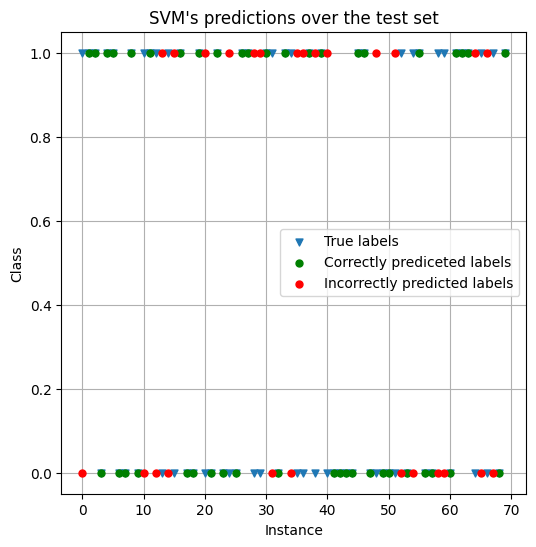

In [7]:
# Plot the predictions over the test set
y_correct_indexes, y_incorrect_indexes = np.where(y_pred == y_test), np.where(y_pred != y_test)
y_correct, y_incorrect = y_pred[y_correct_indexes], y_pred[y_incorrect_indexes]

plt.figure(figsize=(6, 6))
plt.title("SVM's predictions over the test set")
plt.scatter(range(len(y_test)), y_test, s=25.0, marker='v', label='True labels', zorder=2)
plt.scatter(y_correct_indexes, y_correct, s=25.0, label='Correctly prediceted labels', zorder=2, c='green')
plt.scatter(y_incorrect_indexes, y_incorrect, s=25.0, label='Incorrectly predicted labels', zorder=2, c='red')
plt.xlabel("Instance")
plt.ylabel("Class")
plt.grid(True)
plt.legend()
plt.show()

## Idea: 
healthy and ill classes cannot be directly derived from the full dataset, can we create a dedicate SVM for the 
detection of addiction of each topic
1. run classisification (task 2)
2. run the appropriate svm for detection of addiction in that class

In [10]:
df_task1_dedicate = {
    "betting": df_supervised_task1.iloc[df_supervised_task2[df_supervised_task2["Target"] == "betting"].index],
    "trading": df_supervised_task1.iloc[df_supervised_task2[df_supervised_task2["Target"] == "trading"].index],
    "onlinegaming": df_supervised_task1.iloc[df_supervised_task2[df_supervised_task2["Target"] == "onlinegaming"].index],
    "lootboxes": df_supervised_task1.iloc[df_supervised_task2[df_supervised_task2["Target"] == "lootboxes"].index],
    }

for k, v in df_task1_dedicate.items():
    print(k, v.shape)

betting (87, 17412)
trading (137, 17412)
onlinegaming (106, 17412)
lootboxes (27, 17412)


In [12]:
# Perform the train-test split
for topic in df_task1_dedicate:
    print(f"INFO: dedicate svm for --- {topic.upper()} --- detection")
    X, y = df_task1_dedicate[topic].drop(columns=['Target'], axis=1), df_task1_dedicate[topic]['Target'].to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size=0.2, 
                                                        random_state=42, 
                                                        stratify=y, 
                                                        shuffle=True)
    print(f"INFO: train {X_train.shape}, test {X_test.shape}")

    # Train the SVM
    clf_svm = LinearSVC()
    clf_svm.fit(X_train, y_train)

    # Evaluate with test
    y_pred = clf_svm.predict(X_test)
    acc    = accuracy_score(y_true=y_test, y_pred=y_pred)
    print(f"SVM accuracy: {round(acc, 2)}")
    print(classification_report(y_test, y_pred, zero_division=np.nan))

INFO: dedicate svm for --- BETTING --- detection
INFO: train (69, 17411), test (18, 17411)
SVM accuracy: 0.5
              precision    recall  f1-score   support

           0       0.44      0.50      0.47         8
           1       0.56      0.50      0.53        10

    accuracy                           0.50        18
   macro avg       0.50      0.50      0.50        18
weighted avg       0.51      0.50      0.50        18

INFO: dedicate svm for --- TRADING --- detection
INFO: train (109, 17411), test (28, 17411)
SVM accuracy: 0.71
              precision    recall  f1-score   support

           0       0.72      0.81      0.76        16
           1       0.70      0.58      0.64        12

    accuracy                           0.71        28
   macro avg       0.71      0.70      0.70        28
weighted avg       0.71      0.71      0.71        28

INFO: dedicate svm for --- ONLINEGAMING --- detection
INFO: train (84, 17411), test (22, 17411)
SVM accuracy: 0.82
           

In [14]:
# Perform the train-test split
dedicate_svms = {}
dedicate_svms_params = {}
for topic in df_task1_dedicate:
    print(f"INFO: dedicate svm for --- {topic.upper()} --- detection")
    X, y = df_task1_dedicate[topic].drop(columns=['Target'], axis=1), df_task1_dedicate[topic]['Target'].to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size=0.2, 
                                                        random_state=137, 
                                                        stratify=y, 
                                                        shuffle=True)
    print(f"INFO: train {X_train.shape}, test {X_test.shape}")

    param_grid_svm = {
        'C': [ 0.1, 1, 2, 3, 7 ],
        'gamma': [ 'scale', 0.01, 0.001, 0.0001 ],
        'kernel': [ 'linear', 'rbf' ]
    }

    svc      = SVC()
    grid_svm = GridSearchCV(svc, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1, verbose=True)
    grid_svm.fit(X_train, y_train)

    # CV results
    print("Best hyper-parameters found:")
    print(grid_svm.best_params_)
    dedicate_svms_params[topic] = grid_svm.best_params_
    print("\nBest cross validation score:")
    print(grid_svm.best_score_)

    # Evaluate with test
    clf_svm = grid_svm.best_estimator_
    dedicate_svms[topic] = clf_svm
    y_pred  = clf_svm.predict(X_test)
    acc     = accuracy_score(y_true=y_test, y_pred=y_pred)
    print(f"{topic.upper()}-- SVM accuracy: {round(acc, 2)}")
    print(classification_report(y_test, y_pred))

INFO: dedicate svm for --- BETTING --- detection
INFO: train (69, 17411), test (18, 17411)
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best hyper-parameters found:
{'C': 3, 'gamma': 'scale', 'kernel': 'linear'}

Best cross validation score:
0.7241758241758243
BETTING-- SVM accuracy: 0.72
              precision    recall  f1-score   support

           0       0.80      0.50      0.62         8
           1       0.69      0.90      0.78        10

    accuracy                           0.72        18
   macro avg       0.75      0.70      0.70        18
weighted avg       0.74      0.72      0.71        18

INFO: dedicate svm for --- TRADING --- detection
INFO: train (109, 17411), test (28, 17411)
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best hyper-parameters found:
{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}

Best cross validation score:
0.7341991341991342
TRADING-- SVM accuracy: 0.79
              precision    recall  f1-score   support

   

## Training the final dedicated models - Task 1

In [15]:
for topic in df_task1_dedicate:
    print(f"INFO: dedicate svm for --- {topic.upper()} --- detection")
    X, y = df_task1_dedicate[topic].drop(columns=['Target'], axis=1), df_task1_dedicate[topic]['Target'].to_numpy()
    clf_final = SVC(**dedicate_svms_params[topic])
    clf_final.fit(X=X, y=y)

    # Evaluate the final model (CAUTION: THIS METRICS ARE OPTIMISTIC!!! DO NOT USE THEM TO VALIDATE THE MODEL'S GENERALIZATION)
    y_pred = clf_final.predict(X)
    acc    = accuracy_score(y_true=y, y_pred=y_pred)
    print(f"Final SVM accuracy -- {topic.upper()} ---: {round(acc, 2)}")
    print(classification_report(y_true=y, y_pred=y_pred))

    # Store the final model in disk
    joblib.dump(value=clf_final, filename=f'{os.getcwd()}/trained_models/SVM_task1_{topic}.joblib')

joblib.dump(value=vectorizer_task1, filename=f'{os.getcwd()}/trained_models/tfidf_vectorizer_task1_dedicated.joblib')

INFO: dedicate svm for --- BETTING --- detection
Final SVM accuracy -- BETTING ---: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       1.00      1.00      1.00        46

    accuracy                           1.00        87
   macro avg       1.00      1.00      1.00        87
weighted avg       1.00      1.00      1.00        87

INFO: dedicate svm for --- TRADING --- detection
Final SVM accuracy -- TRADING ---: 0.99
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        76
           1       1.00      0.98      0.99        61

    accuracy                           0.99       137
   macro avg       0.99      0.99      0.99       137
weighted avg       0.99      0.99      0.99       137

INFO: dedicate svm for --- ONLINEGAMING --- detection
Final SVM accuracy -- ONLINEGAMING ---: 1.0
              precision    recall  f1-score   support

           0    

['c:\\Users\\maxi.rodriguez\\OneDrive - Align Technology, Inc\\Desktop\\PERSONAL\\master\\NATURAL_LANGUAGE_PROCESSING\\NLP-MENTALRISK-IBERLEF-2025/trained_models/tfidf_vectorizer_task1_dedicated.joblib']

## Constructing the pipeline

In [25]:
topics = ['betting', 'trading', 'onlinegaming', 'lootboxes']

vectorizer_tfidf_task1 = joblib.load("trained_models/tfidf_vectorizer_task1_emojis.joblib")
vectorizer_tfidf_task2 = joblib.load("trained_models/tfidf_vectorizer_task2_emojis.joblib")

model_rf_task2 = joblib.load("trained_models/RF_task2_emojis.joblib")

svm_models_task1 = {
    k: joblib.load(f"trained_models/SVM_task1_{k}.joblib") for k in topics
}

In [65]:
def user_document_to_input(message, trained_vectorizer):
    tokenizer = TweetTokenizer()
    
    # Remove emojis and tokenize
    tokens = tokenizer.tokenize(remove_emojis(message))
    clear_tokens(tokens)
    # Remove punctuation tokens
    # tokens = [clear_tokens(token) for token in tokens]# if token.isalnum()]
    
    # Join tokens into a single document string
    user_document = " ".join(tokens)
    
    X = trained_vectorizer.transform([user_document])
    return pd.DataFrame(X.toarray(), columns=trained_vectorizer.get_feature_names_out())

user_document_to_input("hola", vectorizer_task1)

,00,000,0000,0000000,00000000000,00000085,00000110,0000014,0000017,000003,...,últimamente,últimas,último,últimos,ún,única,únicamente,único,únicos,útiles
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
topic = "betting"
X, y = df_supervised_task2.drop(columns=['Target'], axis=1), df_supervised_task2['Target'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=137, 
                                                    stratify=y, 
                                                    shuffle=True)
user_input = user_document_to_input(
    "ejemplo, acciones",
    vectorizer_task2,
    )

rf_pred = model_rf_task2.predict(user_input)
print(rf_pred[0])
int(svm_models_task1[
    rf_pred[0]
].predict(user_input)[0])

lootboxes


0

In [126]:
class Pipeline:
    def predict(self, user_input):
        rf_pred = model_rf_task2.predict(user_input)
        return svm_models_task1[rf_pred[0]].predict(user_input)

In [128]:
Pipeline().predict(user_input)[0]

np.int8(0)